In [1]:
from google.colab import drive
drive.mount('/content/drive')

video_path = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/Video Segmentation.mp4"
base_dir   = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation"

Mounted at /content/drive


In [2]:
import os

raw_dir     = os.path.join(base_dir, "data/raw_frames")
sampled_dir = os.path.join(base_dir, "data/sampled_frames")

os.makedirs(raw_dir, exist_ok=True)
os.makedirs(sampled_dir, exist_ok=True)

In [3]:
import cv2
import os
import math

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_sec = total_frames / fps

print("FPS:", fps)
print("Total frames:", total_frames)
print("Duración (s):", duration_sec)

# Extraer 1 frame por segundo
step = int(round(fps * 1))  # 1 segundo

frame_idx = 0
saved = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % step == 0:
        out_path = os.path.join(sampled_dir, f"frame_{frame_idx:06d}.jpg")
        cv2.imwrite(out_path, frame)
        saved += 1

    frame_idx += 1

cap.release()
print("Frames guardados:", saved)

FPS: 30.0
Total frames: 764
Duración (s): 25.466666666666665
Frames guardados: 26


In [4]:
import pandas as pd
import glob

files = sorted(glob.glob(os.path.join(sampled_dir, "*.jpg")))

rows = []
for f in files:
    rows.append({"filename": os.path.basename(f), "path": f})

df = pd.DataFrame(rows)
csv_path = os.path.join(base_dir, "data/eda/frames_index.csv")
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df.to_csv(csv_path, index=False)

print("CSV guardado en:", csv_path)
df.head()

CSV guardado en: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_index.csv


,filename,path
0,frame_000000.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...
1,frame_000030.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...
2,frame_000060.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...
3,frame_000090.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...
4,frame_000120.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...


In [5]:
import numpy as np
import pandas as pd
import cv2
import glob, os

# Lista de imágenes
files = sorted(glob.glob(os.path.join(sampled_dir, "*.jpg")))

# Índice con rutas (df)
df = pd.DataFrame({
    "filename": [os.path.basename(f) for f in files],
    "path": files
})

# Calculamos métricas y construir stats
def image_stats(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    brightness = float(np.mean(gray))
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    return brightness, blur

stats = []
for f in files:
    img = cv2.imread(f)
    if img is None:
        continue  # por si alguna imagen está corrupta
    b, bl = image_stats(img)
    stats.append({
        "filename": os.path.basename(f),
        "brightness": b,
        "blur": bl
    })

# df_stats
df_stats = pd.DataFrame(stats)

# 5) Merge para agregar path
df_stats = df_stats.merge(df[["filename", "path"]], on="filename", how="left")

print("df_stats listo. Columnas:", df_stats.columns.tolist())
print("Paths nulos:", df_stats["path"].isna().sum())
df_stats.head()

df_stats listo. Columnas: ['filename', 'brightness', 'blur', 'path']
Paths nulos: 0


,filename,brightness,blur,path
0,frame_000000.jpg,97.924965,141.190448,/content/drive/MyDrive/Proyecto Integrador Equ...
1,frame_000030.jpg,96.214860,163.124427,/content/drive/MyDrive/Proyecto Integrador Equ...
2,frame_000060.jpg,95.633990,200.598275,/content/drive/MyDrive/Proyecto Integrador Equ...
3,frame_000090.jpg,95.607826,193.733635,/content/drive/MyDrive/Proyecto Integrador Equ...
4,frame_000120.jpg,95.735885,124.898713,/content/drive/MyDrive/Proyecto Integrador Equ...


# Análisis Univariante

In [6]:
import numpy as np
import pandas as pd
import cv2
import os

def image_stats(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    brightness = float(np.mean(gray))
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())  # varianza del Laplaciano
    return brightness, blur

stats = []
for f in files:
    img = cv2.imread(f)
    b, bl = image_stats(img)
    stats.append({
        "filename": os.path.basename(f),
        "brightness": b,
        "blur": bl
    })

# Se recrea df_stats
df_stats = pd.DataFrame(stats)

# Se realiza el merge para tener el path
if "df" in globals() and set(["filename", "path"]).issubset(df.columns):
    df_index = df[["filename", "path"]].copy()
else:
    df_index = pd.DataFrame({
        "filename": [os.path.basename(f) for f in files],
        "path": files
    })

df_stats = df_stats.merge(df_index, on="filename", how="left")

df_stats["blur_level"] = np.where(df_stats["blur"] < df_stats["blur"].median(), "low", "high")
df_stats["brightness_level"] = np.where(df_stats["brightness"] < df_stats["brightness"].median(), "low", "high")

# Verificamos nulos en columna path
print("Paths nulos:", df_stats["path"].isna().sum())

# Se imprime caracteristicas
df_stats.describe()


Paths nulos: 0


,brightness,blur
count,26.000000,26.000000
mean,96.658097,279.899885
std,1.679035,146.388631
min,93.656030,74.377834
25%,95.652961,146.673943
50%,96.028158,267.686260
75%,97.909873,409.849196
max,100.186598,523.179817


In [7]:
# Guardar métricas EDA en el CSV se incluye el path
eda_csv_path = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda.csv"
df_stats.to_csv(eda_csv_path, index=False)
print("CSV EDA guardado en:", eda_csv_path)

CSV EDA guardado en: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda.csv


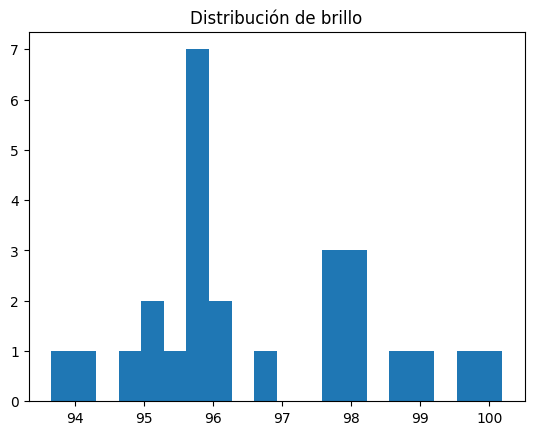

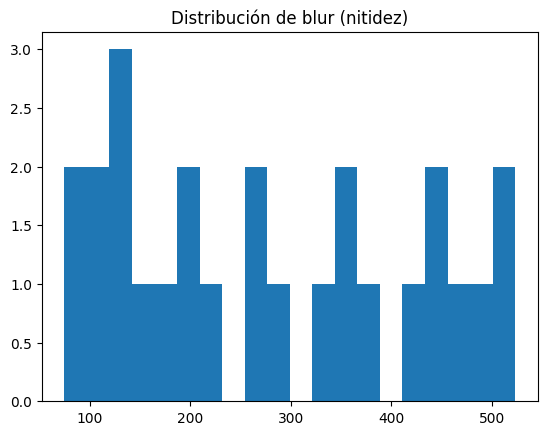

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_stats["brightness"], bins=20)
plt.title("Distribución de brillo")
plt.show()

plt.figure()
plt.hist(df_stats["blur"], bins=20)
plt.title("Distribución de blur (nitidez)")
plt.show()

# Analisis Bi/Multivariable

Correlación Pearson (brightness vs blur): -0.16713418126950058


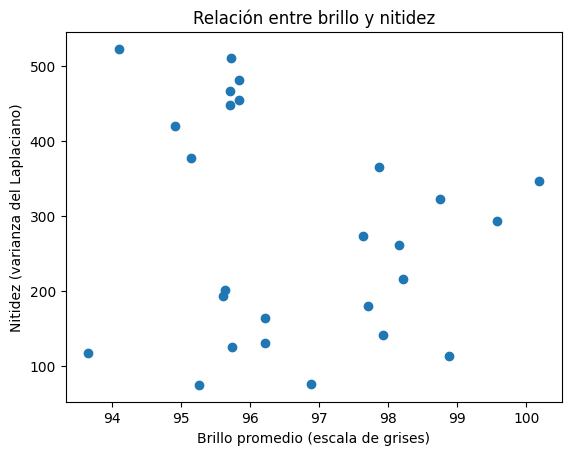

In [9]:
import matplotlib.pyplot as plt
import numpy as np

corr = df_stats["brightness"].corr(df_stats["blur"], method="pearson")
print("Correlación Pearson (brightness vs blur):", corr)

plt.figure()
plt.scatter(df_stats["brightness"], df_stats["blur"])
plt.xlabel("Brillo promedio (escala de grises)")
plt.ylabel("Nitidez (varianza del Laplaciano)")
plt.title("Relación entre brillo y nitidez")
plt.show()

In [10]:
#Creación de Rangos de Nitidez
# Se toma la mediana de la variable como umbral, determinando el valor de nitidez de una imagen como menor si está
# por dejabo o mayor / High si está por encima.

df_stats["blur_level"] = np.where(
    df_stats["blur"] < df_stats["blur"].median(), "low", "high"
)

# Se aplica el mismo criterio sobre el brillo

df_stats["brightness_level"] = np.where(
    df_stats["brightness"] < df_stats["brightness"].median(), "low", "high"
)

pd.crosstab(df_stats["blur_level"], df_stats["brightness_level"])

brightness_level,high,low
blur_level,,
high,5,8
low,8,5


# Preprocesamiento

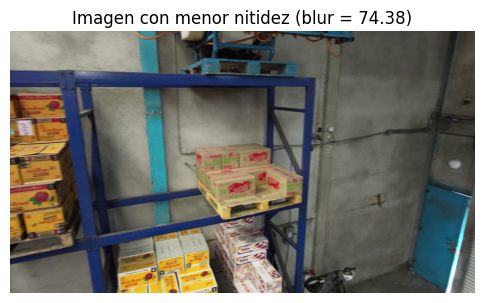

In [11]:
import cv2
import matplotlib.pyplot as plt

worst_row = df_stats.loc[df_stats["blur"].idxmin()]
worst_image_path = worst_row["path"]
worst_blur_value = worst_row["blur"]

img = cv2.imread(worst_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,4))
plt.imshow(img_rgb)
plt.title(f"Imagen con menor nitidez (blur = {worst_blur_value:.2f})")
plt.axis("off")
plt.show()

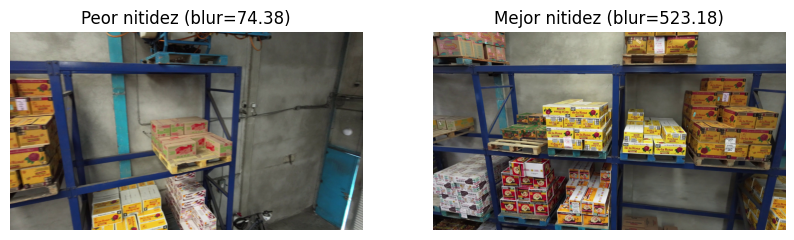

In [12]:
# Comparar peor y mejor imagen
best_row = df_stats.loc[df_stats["blur"].idxmax()]

img_worst = cv2.cvtColor(cv2.imread(worst_row["path"]), cv2.COLOR_BGR2RGB)
img_best  = cv2.cvtColor(cv2.imread(best_row["path"]), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_worst)
plt.title(f"Peor nitidez (blur={worst_row['blur']:.2f})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_best)
plt.title(f"Mejor nitidez (blur={best_row['blur']:.2f})")
plt.axis("off")

plt.show()

In [13]:
# Aplicamos el filtro de Imagen acuerdo a la nitidez
import numpy as np

# Umbral: primer cuartil (25%) de blur
blur_threshold = df_stats["blur"].quantile(0.25)

df_filtered = df_stats[df_stats["blur"] >= blur_threshold].copy()
df_discarded = df_stats[df_stats["blur"] < blur_threshold].copy()

print("Total original:", len(df_stats))
print("Descartadas (blur bajo):", len(df_discarded))
print("Restantes:", len(df_filtered))
print("Umbral blur (Q1):", blur_threshold)


Total original: 26
Descartadas (blur bajo): 7
Restantes: 19
Umbral blur (Q1): 146.6739427950466


In [14]:
import os
import shutil

# Carpeta destino en inglés
processed_dir = os.path.join(base_dir, "data", "Processed Images")
os.makedirs(processed_dir, exist_ok=True)

# Copiar imágenes filtradas manteniendo el nombre original
for src_path in df_filtered["path"]:
    filename = os.path.basename(src_path)  # frame_000XXX.jpg
    dst_path = os.path.join(processed_dir, filename)
    shutil.copy2(src_path, dst_path)

print(f"{len(df_filtered)} images copied to:\n{processed_dir}")

19 images copied to:
/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/Processed Images


In [15]:
filtered_csv_path = "/content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda_filtered.csv"
df_filtered.to_csv(filtered_csv_path, index=False)
print("CSV filtrado guardado en:", filtered_csv_path)

CSV filtrado guardado en: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/eda/frames_eda_filtered.csv


In [16]:
# =========================
# (CELDA 18) Feature Engineering: crear nuevas características desde Processed Images
# =========================
import os, glob
import numpy as np
import pandas as pd
import cv2

def compute_entropy(gray: np.ndarray, bins: int = 256) -> float:
    """Entropía de intensidades en escala de grises."""
    hist = cv2.calcHist([gray], [0], None, [bins], [0, 256]).ravel()
    p = hist / (hist.sum() + 1e-12)
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def compute_edge_density(gray: np.ndarray) -> float:
    """
    Densidad de bordes usando Canny con umbrales automáticos basados en la mediana.
    """
    med = np.median(gray)
    lower = int(max(0, 0.66 * med))
    upper = int(min(255, 1.33 * med))
    edges = cv2.Canny(gray, lower, upper)
    return float(np.count_nonzero(edges) / edges.size)

def extract_features_from_image(img_path: str) -> dict:
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        return {"_read_error": 1}

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    hsv  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    brightness = float(np.mean(gray))
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())

    # Nuevas features (Construcción)
    contrast = float(np.std(gray))                 # variación de intensidad
    edge_density = compute_edge_density(gray)      # proxy de contornos/cajas visibles
    entropy = compute_entropy(gray)                # textura/variabilidad
    saturation_mean = float(np.mean(hsv[:, :, 1])) # robustez ante iluminación

    # Features derivadas/transformaciones
    sharpness_norm = float(blur / (brightness + 1e-6))
    log_blur = float(np.log(blur + 1e-6))

    return {
        "brightness": brightness,
        "blur": blur,
        "contrast": contrast,
        "edge_density": edge_density,
        "entropy": entropy,
        "saturation_mean": saturation_mean,
        "sharpness_norm": sharpness_norm,
        "log_blur": log_blur,
        "_read_error": 0
    }

# Leer imágenes desde Processed Images
processed_files = sorted(glob.glob(os.path.join(processed_dir, "*.jpg")) +
                         glob.glob(os.path.join(processed_dir, "*.png")))

print("Imágenes en Processed Images:", len(processed_files))
if len(processed_files) == 0:
    raise ValueError("No hay imágenes en Processed Images. Revisa processed_dir.")

# Extraer features
rows = []
for p in processed_files:
    feats = extract_features_from_image(p)
    rows.append({
        "filename": os.path.basename(p),
        "processed_path": p,
        **feats
    })

df_fe = pd.DataFrame(rows)
df_fe = df_fe[df_fe["_read_error"] == 0].drop(columns=["_read_error"]).copy()

# Integrar con tu df_filtered (trazabilidad)
# df_filtered ya tiene filename/path/brightness/blur (de sampled_dir). Conservamos ambos y agregamos nuevas features.
df_ready = df_filtered.drop(columns=[c for c in ["brightness","blur"] if c in df_filtered.columns], errors="ignore") \
                      .merge(df_fe, on="filename", how="inner")

print("df_filtered:", len(df_filtered))
print("df_fe:", len(df_fe))
print("df_ready (merge):", len(df_ready))
df_ready.head()


Imágenes en Processed Images: 19
df_filtered: 19
df_fe: 19
df_ready (merge): 19


,filename,path,blur_level,brightness_level,processed_path,brightness,blur,contrast,edge_density,entropy,saturation_mean,sharpness_norm,log_blur
0,frame_000030.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...,low,high,/content/drive/MyDrive/Proyecto Integrador Equ...,96.214860,163.124427,46.328063,0.051737,7.449564,65.713707,1.695418,5.094513
1,frame_000060.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...,low,low,/content/drive/MyDrive/Proyecto Integrador Equ...,95.633990,200.598275,49.246988,0.063059,7.529134,73.076691,2.097563,5.301304
2,frame_000090.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...,low,low,/content/drive/MyDrive/Proyecto Integrador Equ...,95.607826,193.733635,45.838001,0.056223,7.438778,68.080217,2.026337,5.266484
3,frame_000240.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...,low,high,/content/drive/MyDrive/Proyecto Integrador Equ...,97.708086,180.046116,44.506192,0.057553,7.423158,57.217865,1.842694,5.193213
4,frame_000270.jpg,/content/drive/MyDrive/Proyecto Integrador Equ...,low,high,/content/drive/MyDrive/Proyecto Integrador Equ...,98.216906,216.369864,43.798871,0.062733,7.409961,56.854243,2.202980,5.376989


In [17]:
# =========================
# (CELDA 19) Discretización (binning) + codificación (ordinal/binary)
# =========================
import numpy as np

# Binning por cuantiles para blur (3 niveles)
q1, q2 = df_ready["blur"].quantile([0.33, 0.66]).values
def blur_level(x):
    if x < q1:
        return "low"
    elif x < q2:
        return "medium"
    return "high"

df_ready["blur_level"] = df_ready["blur"].apply(blur_level)

# Binning por mediana para brightness (2 niveles)
b_med = df_ready["brightness"].median()
df_ready["brightness_level"] = (df_ready["brightness"] >= b_med).astype(int)  # 0 bajo, 1 alto

# Codificación ordinal para blur_level
blur_map = {"low": 0, "medium": 1, "high": 2}
df_ready["blur_level_ord"] = df_ready["blur_level"].map(blur_map).astype(int)

print("Umbrales blur:", q1, q2)
print("Mediana brightness:", b_med)
df_ready[["filename","brightness","blur","blur_level","blur_level_ord","brightness_level"]].head()

Umbrales blur: 273.1436158782971 415.4522724256654
Mediana brightness: 95.84145543981481


,filename,brightness,blur,blur_level,blur_level_ord,brightness_level
0,frame_000030.jpg,96.214860,163.124427,low,0,1
1,frame_000060.jpg,95.633990,200.598275,low,0,0
2,frame_000090.jpg,95.607826,193.733635,low,0,0
3,frame_000240.jpg,97.708086,180.046116,low,0,1
4,frame_000270.jpg,98.216906,216.369864,low,0,1


In [18]:
# =========================
# (CELDA 20) Normalización / escalamiento + (ya tenemos log_blur)
# =========================
from sklearn.preprocessing import StandardScaler

# Features numéricas para modelado (incluimos ordinal y binarias si lo desean)
feature_cols = [
    "brightness", "blur", "log_blur",
    "contrast", "edge_density", "entropy", "saturation_mean", "sharpness_norm",
    "blur_level_ord", "brightness_level"
]

X = df_ready[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=[f"{c}_z" for c in feature_cols])
df_scaled.insert(0, "filename", df_ready["filename"].values)

print("Matriz escalada:", df_scaled.shape)
df_scaled.head()

Matriz escalada: (19, 11)


,filename,brightness_z,blur_z,log_blur_z,contrast_z,edge_density_z,entropy_z,saturation_mean_z,sharpness_norm_z,blur_level_ord_z,brightness_level_z
0,frame_000030.jpg,-0.334285,-1.535658,-1.822534,-1.422124,-1.866355,-1.568779,-1.455188,-1.491049,-1.275153,0.948683
1,frame_000060.jpg,-0.686605,-1.214197,-1.264938,-0.500252,-1.179385,-0.544520,-0.796406,-1.166953,-1.275153,-1.054093
2,frame_000090.jpg,-0.702474,-1.273083,-1.358828,-1.576898,-1.594166,-1.707622,-1.243451,-1.224356,-1.275153,-1.054093
3,frame_000240.jpg,0.571415,-1.390499,-1.556398,-1.997518,-1.513492,-1.908691,-2.215329,-1.372356,-1.275153,0.948683
4,frame_000270.jpg,0.880034,-1.078903,-1.060860,-2.220908,-1.199136,-2.078567,-2.247863,-1.081996,-1.275153,0.948683


In [19]:
# =========================
# (CELDA 21) Selección (filtrado): Umbral de varianza + Correlación
# =========================
from sklearn.feature_selection import VarianceThreshold

# 1) Umbral de varianza (sobre variables escaladas)
Xz = df_scaled.drop(columns=["filename"])
vt = VarianceThreshold(threshold=0.01)  # pequeño porque ya está escalado
X_vt = vt.fit_transform(Xz)

kept_cols_vt = Xz.columns[vt.get_support()].tolist()
removed_cols_vt = [c for c in Xz.columns if c not in kept_cols_vt]

print("Features originales:", Xz.shape[1])
print("Features tras varianza:", len(kept_cols_vt))
print("Eliminadas por varianza baja:", removed_cols_vt)

df_vt = pd.DataFrame(X_vt, columns=kept_cols_vt)
df_vt.insert(0, "filename", df_scaled["filename"].values)

# 2) Filtrado por correlación (quita redundancia)
corr = df_vt.drop(columns=["filename"]).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.90)]

print("Eliminadas por correlación alta (>0.90):", to_drop_corr)

df_sel = df_vt.drop(columns=to_drop_corr).copy()
print("Features finales tras selección:", df_sel.shape)
df_sel.head()

Features originales: 10
Features tras varianza: 10
Eliminadas por varianza baja: []
Eliminadas por correlación alta (>0.90): ['log_blur_z', 'edge_density_z', 'entropy_z', 'saturation_mean_z', 'sharpness_norm_z', 'blur_level_ord_z']
Features finales tras selección: (19, 5)


,filename,brightness_z,blur_z,contrast_z,brightness_level_z
0,frame_000030.jpg,-0.334285,-1.535658,-1.422124,0.948683
1,frame_000060.jpg,-0.686605,-1.214197,-0.500252,-1.054093
2,frame_000090.jpg,-0.702474,-1.273083,-1.576898,-1.054093
3,frame_000240.jpg,0.571415,-1.390499,-1.997518,0.948683
4,frame_000270.jpg,0.880034,-1.078903,-2.220908,0.948683


Componentes totales: 4
k (>=90% varianza): 3
Varianza acumulada en k: 0.9541600150501145


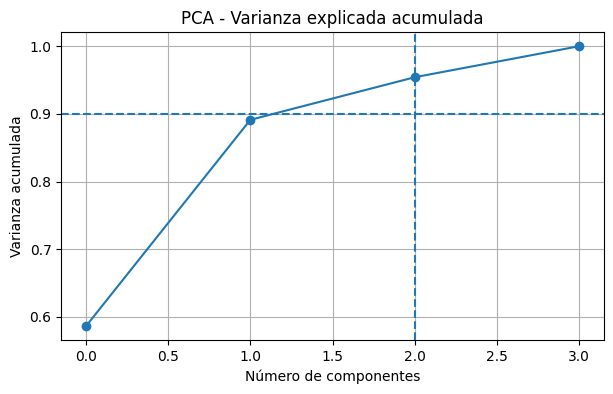

,filename,PC1,PC2,PC3
0,frame_000030.jpg,1.706387,-1.373387,0.084383
1,frame_000060.jpg,-0.094036,-1.519265,-0.993862
2,frame_000090.jpg,0.320536,-2.304731,-0.444288
3,frame_000240.jpg,2.301895,-1.284442,0.445193
4,frame_000270.jpg,2.371902,-1.177264,0.772754


In [20]:
# =========================
# (CELDA 22) Extracción: PCA (reduce dimensionalidad) + varianza explicada
# =========================
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_sel = df_sel.drop(columns=["filename"]).values

pca = PCA()
X_pca_all = pca.fit_transform(X_sel)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Elegir k para cubrir 90% de varianza (ajustable)
k = int(np.argmax(cum_explained >= 0.90) + 1)

print("Componentes totales:", len(explained))
print("k (>=90% varianza):", k)
print("Varianza acumulada en k:", cum_explained[k-1])

# Plot varianza acumulada
plt.figure(figsize=(7,4))
plt.plot(cum_explained, marker="o")
plt.axhline(0.90, linestyle="--")
plt.axvline(k-1, linestyle="--")
plt.title("PCA - Varianza explicada acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()

# Dataset PCA final
df_pca = pd.DataFrame(X_pca_all[:, :k], columns=[f"PC{i+1}" for i in range(k)])
df_pca.insert(0, "filename", df_sel["filename"].values)

df_pca.head()

In [21]:
# =========================
# (CELDA 23) Guardar entregables de Avance 2 (features, escalado, selección, PCA)
# =========================
out_dir = os.path.join(base_dir, "data", "fe")
os.makedirs(out_dir, exist_ok=True)

paths = {
    "features_full": os.path.join(out_dir, "frames_features_full.csv"),
    "features_scaled": os.path.join(out_dir, "frames_features_scaled.csv"),
    "features_selected": os.path.join(out_dir, "frames_features_selected.csv"),
    "features_pca": os.path.join(out_dir, "frames_features_pca.csv"),
}

df_ready.to_csv(paths["features_full"], index=False)
df_scaled.to_csv(paths["features_scaled"], index=False)
df_sel.to_csv(paths["features_selected"], index=False)
df_pca.to_csv(paths["features_pca"], index=False)

print("Archivos guardados:")
for k,v in paths.items():
    print(f"- {k}: {v}")

Archivos guardados:
- features_full: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_full.csv
- features_scaled: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_scaled.csv
- features_selected: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_selected.csv
- features_pca: /content/drive/MyDrive/Proyecto Integrador Equipo37/Video Segmentation/data/fe/frames_features_pca.csv
